In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 11

print("✅ Libraries imported successfully")
print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")

✅ Libraries imported successfully
Pandas Version: 2.3.0
NumPy Version: 1.26.4


In [6]:
def load_data_folder(folder_path):
    """Load and combine all CSV files from a folder"""
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    
    if not csv_files:
        print(f"⚠️ WARNING: No CSV files found in {folder_path}")
        return pd.DataFrame()
    
    df_list = []
    for f in csv_files:
        df_list.append(pd.read_csv(f))
    
    print(f"✅ Loaded {len(csv_files)} file(s) from {folder_path}")
    return pd.concat(df_list, ignore_index=True)

# Load all datasets
print("📂 LOADING DATASETS...\n")
# Using raw strings (r prefix) to handle Windows file paths correctly
enrolment_df = load_data_folder(r"C:\Users\akshi\Downloads\filesUIDAI\api_data_aadhar_enrolment")
demographic_df = load_data_folder(r"C:\Users\akshi\Downloads\filesUIDAI\api_data_aadhar_demographic")
biometric_df = load_data_folder(r"C:\Users\akshi\Downloads\filesUIDAI\api_data_aadhar_biometric")

print(f"\n📊 DATASET SHAPES:")
print(f"   Enrolment:   {enrolment_df.shape[0]:,} rows × {enrolment_df.shape[1]} columns")
print(f"   Demographic: {demographic_df.shape[0]:,} rows × {demographic_df.shape[1]} columns")
print(f"   Biometric:   {biometric_df.shape[0]:,} rows × {biometric_df.shape[1]} columns")
print(f"\n   TOTAL RECORDS: {enrolment_df.shape[0] + demographic_df.shape[0] + biometric_df.shape[0]:,}")

📂 LOADING DATASETS...

✅ Loaded 3 file(s) from C:\Users\akshi\Downloads\filesUIDAI\api_data_aadhar_enrolment
✅ Loaded 5 file(s) from C:\Users\akshi\Downloads\filesUIDAI\api_data_aadhar_demographic
✅ Loaded 4 file(s) from C:\Users\akshi\Downloads\filesUIDAI\api_data_aadhar_biometric

📊 DATASET SHAPES:
   Enrolment:   1,006,029 rows × 7 columns
   Demographic: 2,071,700 rows × 6 columns
   Biometric:   1,861,108 rows × 6 columns

   TOTAL RECORDS: 4,938,837


In [9]:
def clean_df(df):
    """Standardize column names and remove empty rows"""
    if df.empty:
        return df
    # Lowercase and replace spaces with underscores
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    # Remove completely empty rows
    df = df.dropna(how="all")
    return df

print("🧹 CLEANING DATA...")
enrolment_df = clean_df(enrolment_df)
demographic_df = clean_df(demographic_df)
biometric_df = clean_df(biometric_df)
print("✅ Data cleaned successfully\n")

# Display column information
print("🔍 DATASET COLUMNS:")
print(f"\n📋 Enrolment columns: {enrolment_df.columns.tolist()}")
print(f"\n📋 Demographic columns: {demographic_df.columns.tolist()}")
print(f"\n📋 Biometric columns: {biometric_df.columns.tolist()}")

🧹 CLEANING DATA...
✅ Data cleaned successfully

🔍 DATASET COLUMNS:

📋 Enrolment columns: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater', 'total_enrolment']

📋 Demographic columns: ['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_', 'total_demo_updates']

📋 Biometric columns: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_', 'total_bio_updates']


In [10]:
# Create derived features
if not enrolment_df.empty and all(col in enrolment_df.columns for col in ['age_0_5', 'age_5_17', 'age_18_greater']):
    enrolment_df['total_enrolment'] = enrolment_df['age_0_5'] + enrolment_df['age_5_17'] + enrolment_df['age_18_greater']
    print("✅ Created 'total_enrolment' column")

if not demographic_df.empty and all(col in demographic_df.columns for col in ['demo_age_5_17', 'demo_age_17_']):
    demographic_df['total_demo_updates'] = demographic_df['demo_age_5_17'] + demographic_df['demo_age_17_']
    print("✅ Created 'total_demo_updates' column")

if not biometric_df.empty and all(col in biometric_df.columns for col in ['bio_age_5_17', 'bio_age_17_']):
    biometric_df['total_bio_updates'] = biometric_df['bio_age_5_17'] + biometric_df['bio_age_17_']
    print("✅ Created 'total_bio_updates' column")

# Preview data
print("\n📊 SAMPLE DATA (First 3 rows of Enrolment):")
enrolment_df.head(3)

✅ Created 'total_enrolment' column
✅ Created 'total_demo_updates' column
✅ Created 'total_bio_updates' column

📊 SAMPLE DATA (First 3 rows of Enrolment):


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrolment
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37,109
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39,86
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,123


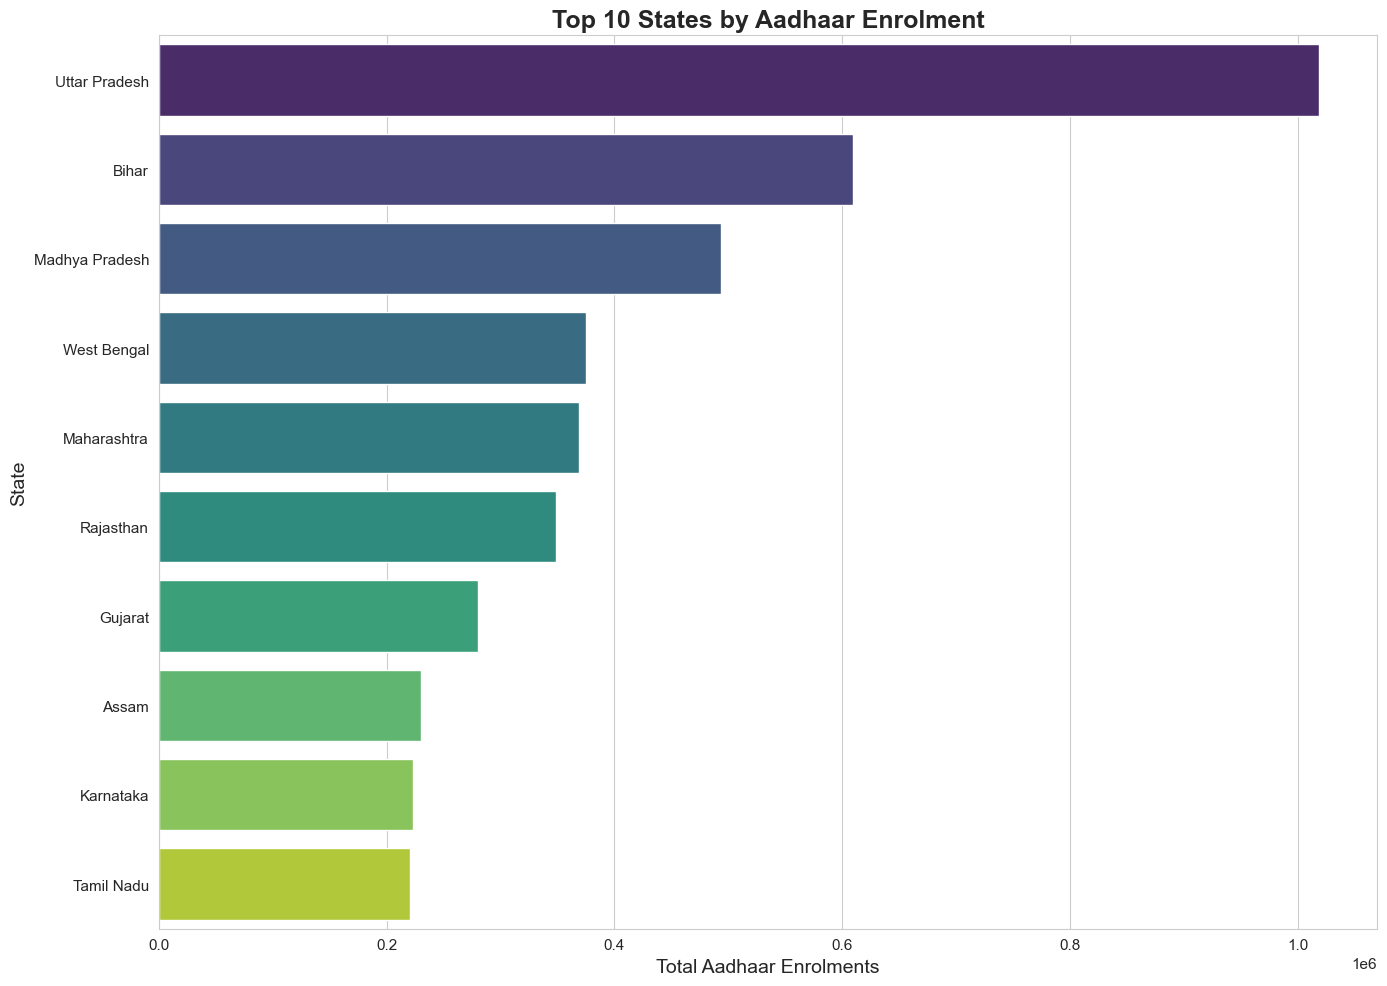

📊 STATE-WISE ENROLMENT STATISTICS:
   🥇 Top State: Uttar Pradesh (1,018,629 enrolments)
   🥈 2nd: Bihar (609,585)
   🥉 3rd: Madhya Pradesh (493,970)
   📉 Lowest: WESTBENGAL (1)

   Total States: 55
   Mean Enrolment per State: 98,831
   Median Enrolment per State: 4,344


In [11]:
# State-wise enrolment aggregation
if not enrolment_df.empty and "state" in enrolment_df.columns:
    state_enrolment = enrolment_df.groupby("state")['total_enrolment'].sum().reset_index()
    state_enrolment = state_enrolment.sort_values(by="total_enrolment", ascending=False)
    
    # Save output
    os.makedirs("outputs/tables", exist_ok=True)
    state_enrolment.to_csv("outputs/tables/state_enrolment.csv", index=False)
    
    # Visualization
    os.makedirs("outputs/charts", exist_ok=True)
    plt.figure(figsize=(14, 10))
    sns.barplot(data=state_enrolment.head(10),
                x="total_enrolment",
                y="state",
                palette="viridis")
    plt.title("Top 10 States by Aadhaar Enrolment", fontsize=18, fontweight="bold")
    plt.xlabel("Total Aadhaar Enrolments", fontsize=14)
    plt.ylabel("State", fontsize=14)
    plt.tight_layout()
    plt.savefig("outputs/charts/top_states_enrolment.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display statistics
    print(f"📊 STATE-WISE ENROLMENT STATISTICS:")
    print(f"   🥇 Top State: {state_enrolment.iloc[0]['state']} ({state_enrolment.iloc[0]['total_enrolment']:,} enrolments)")
    print(f"   🥈 2nd: {state_enrolment.iloc[1]['state']} ({state_enrolment.iloc[1]['total_enrolment']:,})")
    print(f"   🥉 3rd: {state_enrolment.iloc[2]['state']} ({state_enrolment.iloc[2]['total_enrolment']:,})")
    print(f"   📉 Lowest: {state_enrolment.iloc[-1]['state']} ({state_enrolment.iloc[-1]['total_enrolment']:,})")
    print(f"\n   Total States: {len(state_enrolment)}")
    print(f"   Mean Enrolment per State: {state_enrolment['total_enrolment'].mean():,.0f}")
    print(f"   Median Enrolment per State: {state_enrolment['total_enrolment'].median():,.0f}")

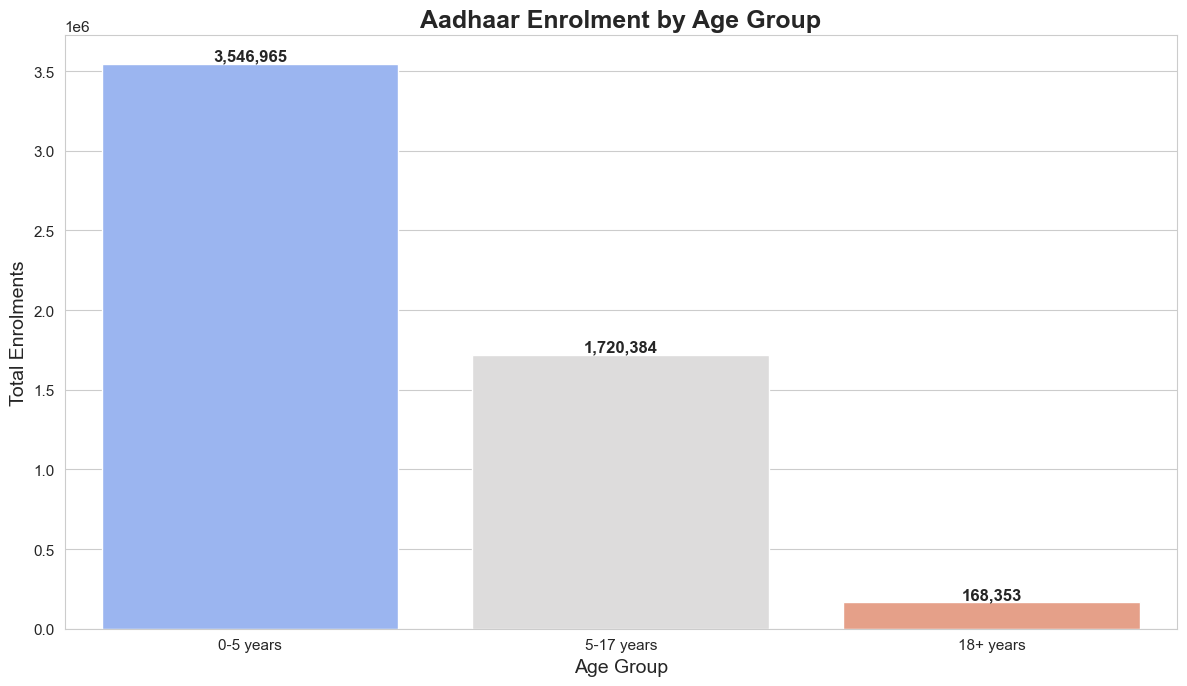

📊 AGE GROUP DISTRIBUTION:
   0-5 years: 3,546,965 (65.3%)
   5-17 years: 1,720,384 (31.6%)
   18+ years: 168,353 (3.1%)

   💡 INSIGHT: Check if children (0-5) or adolescents (5-17) need targeted campaigns


In [12]:
# Age group analysis
if not enrolment_df.empty and all(col in enrolment_df.columns for col in ['age_0_5', 'age_5_17', 'age_18_greater']):
    age_totals = {
        '0-5 years': enrolment_df['age_0_5'].sum(),
        '5-17 years': enrolment_df['age_5_17'].sum(),
        '18+ years': enrolment_df['age_18_greater'].sum()
    }
    
    age_enrolment = pd.DataFrame(list(age_totals.items()), columns=['age_group', 'total'])
    age_enrolment.to_csv("outputs/tables/age_group_enrolment.csv", index=False)
    
    # Visualization
    plt.figure(figsize=(12, 7))
    bars = sns.barplot(data=age_enrolment,
                       x="age_group",
                       y="total",
                       palette="coolwarm")
    
    # Add value labels on bars
    for bar in bars.patches:
        bars.annotate(format(bar.get_height(), ',.0f'),
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     ha='center', va='bottom',
                     fontsize=12, fontweight='bold')
    
    plt.title("Aadhaar Enrolment by Age Group", fontsize=18, fontweight="bold")
    plt.xlabel("Age Group", fontsize=14)
    plt.ylabel("Total Enrolments", fontsize=14)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig("outputs/charts/age_group_enrolment.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistics
    total_all_ages = sum(age_totals.values())
    print(f"📊 AGE GROUP DISTRIBUTION:")
    for age_group, count in age_totals.items():
        percentage = (count / total_all_ages) * 100
        print(f"   {age_group}: {count:,} ({percentage:.1f}%)")
    print(f"\n   💡 INSIGHT: Check if children (0-5) or adolescents (5-17) need targeted campaigns")

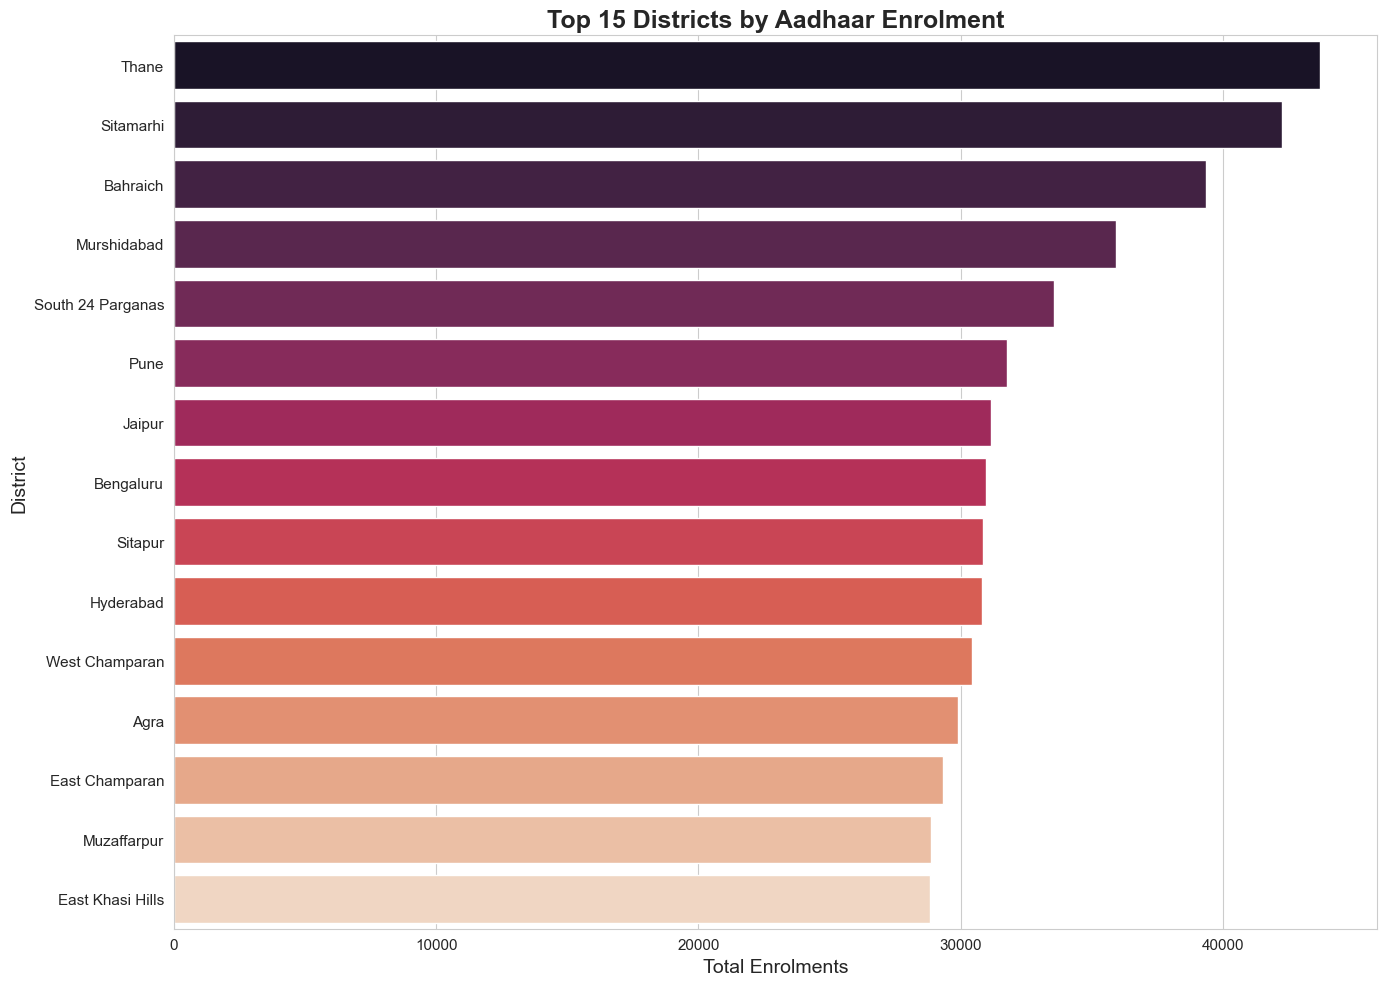

📊 DISTRICT-LEVEL INSIGHTS:
   🥇 Top District: Thane (43,688)
   Total Districts: 985
   Average per District: 5,518


In [13]:
# District-level analysis
if not enrolment_df.empty and "district" in enrolment_df.columns:
    district_enrolment = enrolment_df.groupby("district")['total_enrolment'].sum().reset_index()
    district_enrolment = district_enrolment.sort_values(by="total_enrolment", ascending=False)
    
    district_enrolment.to_csv("outputs/tables/district_enrolment.csv", index=False)
    
    # Visualization
    plt.figure(figsize=(14, 10))
    sns.barplot(data=district_enrolment.head(15),
                x="total_enrolment",
                y="district",
                palette="rocket")
    plt.title("Top 15 Districts by Aadhaar Enrolment", fontsize=18, fontweight="bold")
    plt.xlabel("Total Enrolments", fontsize=14)
    plt.ylabel("District", fontsize=14)
    plt.tight_layout()
    plt.savefig("outputs/charts/top_districts_enrolment.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 DISTRICT-LEVEL INSIGHTS:")
    print(f"   🥇 Top District: {district_enrolment.iloc[0]['district']} ({district_enrolment.iloc[0]['total_enrolment']:,})")
    print(f"   Total Districts: {len(district_enrolment)}")
    print(f"   Average per District: {district_enrolment['total_enrolment'].mean():,.0f}")

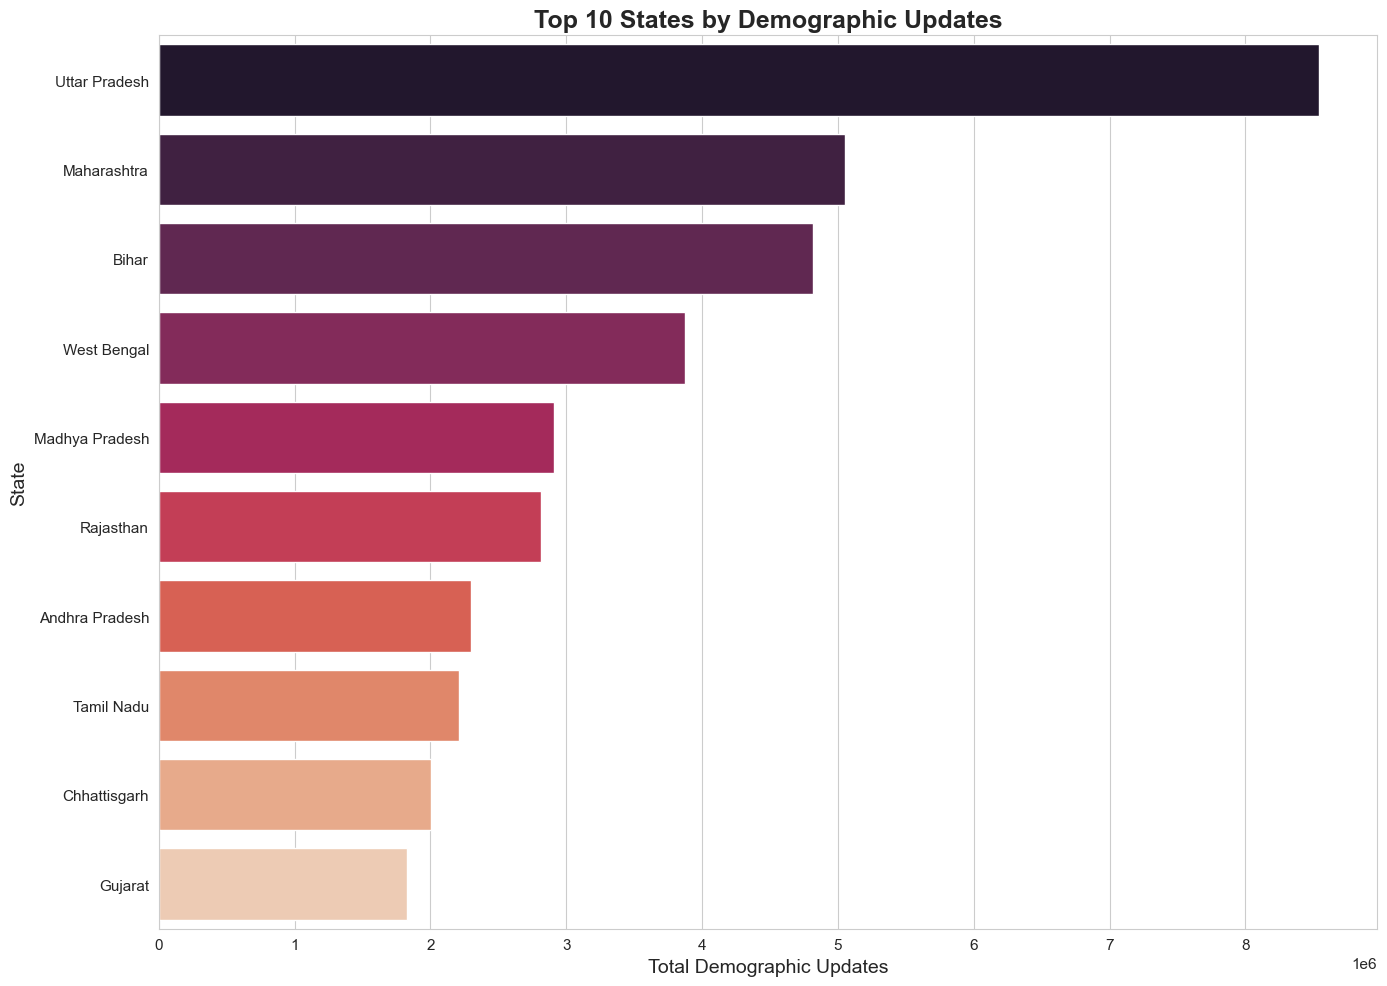

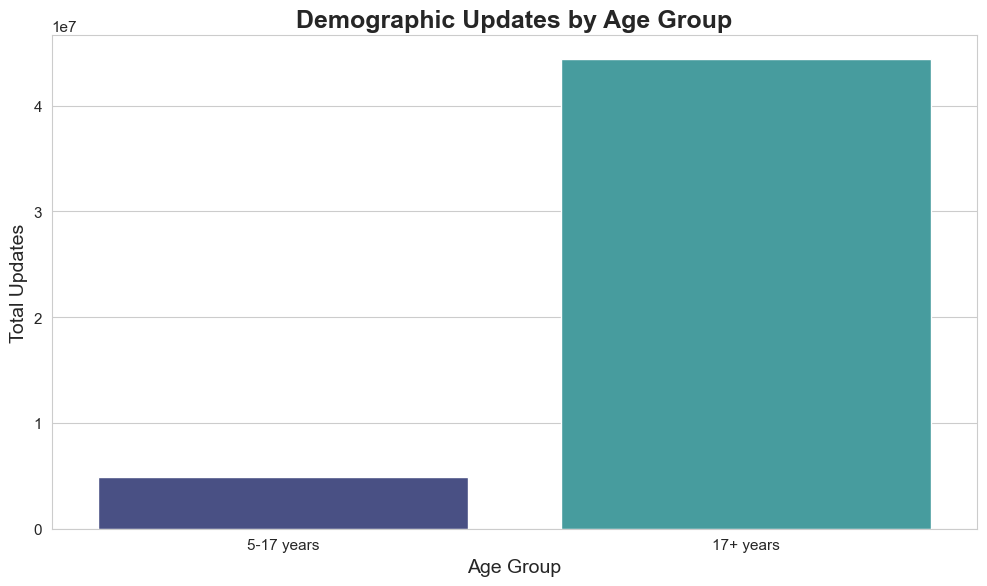

📊 DEMOGRAPHIC UPDATE INSIGHTS:
   🥇 Top State: Uttar Pradesh (8,542,328 updates)
   📌 INSIGHT: High updates may indicate migration hotspots or address changes


In [14]:
# Demographic update analysis
if not demographic_df.empty and "state" in demographic_df.columns:
    demo_state = demographic_df.groupby("state")['total_demo_updates'].sum().reset_index()
    demo_state = demo_state.sort_values(by="total_demo_updates", ascending=False)
    
    demo_state.to_csv("outputs/tables/demographic_updates_by_state.csv", index=False)
    
    # Visualization 1: State-wise
    plt.figure(figsize=(14, 10))
    sns.barplot(data=demo_state.head(10),
                x="total_demo_updates",
                y="state",
                palette="rocket")
    plt.title("Top 10 States by Demographic Updates", fontsize=18, fontweight="bold")
    plt.xlabel("Total Demographic Updates", fontsize=14)
    plt.ylabel("State", fontsize=14)
    plt.tight_layout()
    plt.savefig("outputs/charts/demographic_updates.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Visualization 2: Age group comparison
    demo_age_totals = {
        '5-17 years': demographic_df['demo_age_5_17'].sum(),
        '17+ years': demographic_df['demo_age_17_'].sum()
    }
    
    demo_age_df = pd.DataFrame(list(demo_age_totals.items()), columns=['age_group', 'total_updates'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=demo_age_df,
                x="age_group",
                y="total_updates",
                palette="mako")
    plt.title("Demographic Updates by Age Group", fontsize=18, fontweight="bold")
    plt.xlabel("Age Group", fontsize=14)
    plt.ylabel("Total Updates", fontsize=14)
    plt.tight_layout()
    plt.savefig("outputs/charts/demographic_updates_age.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 DEMOGRAPHIC UPDATE INSIGHTS:")
    print(f"   🥇 Top State: {demo_state.iloc[0]['state']} ({demo_state.iloc[0]['total_demo_updates']:,} updates)")
    print(f"   📌 INSIGHT: High updates may indicate migration hotspots or address changes")

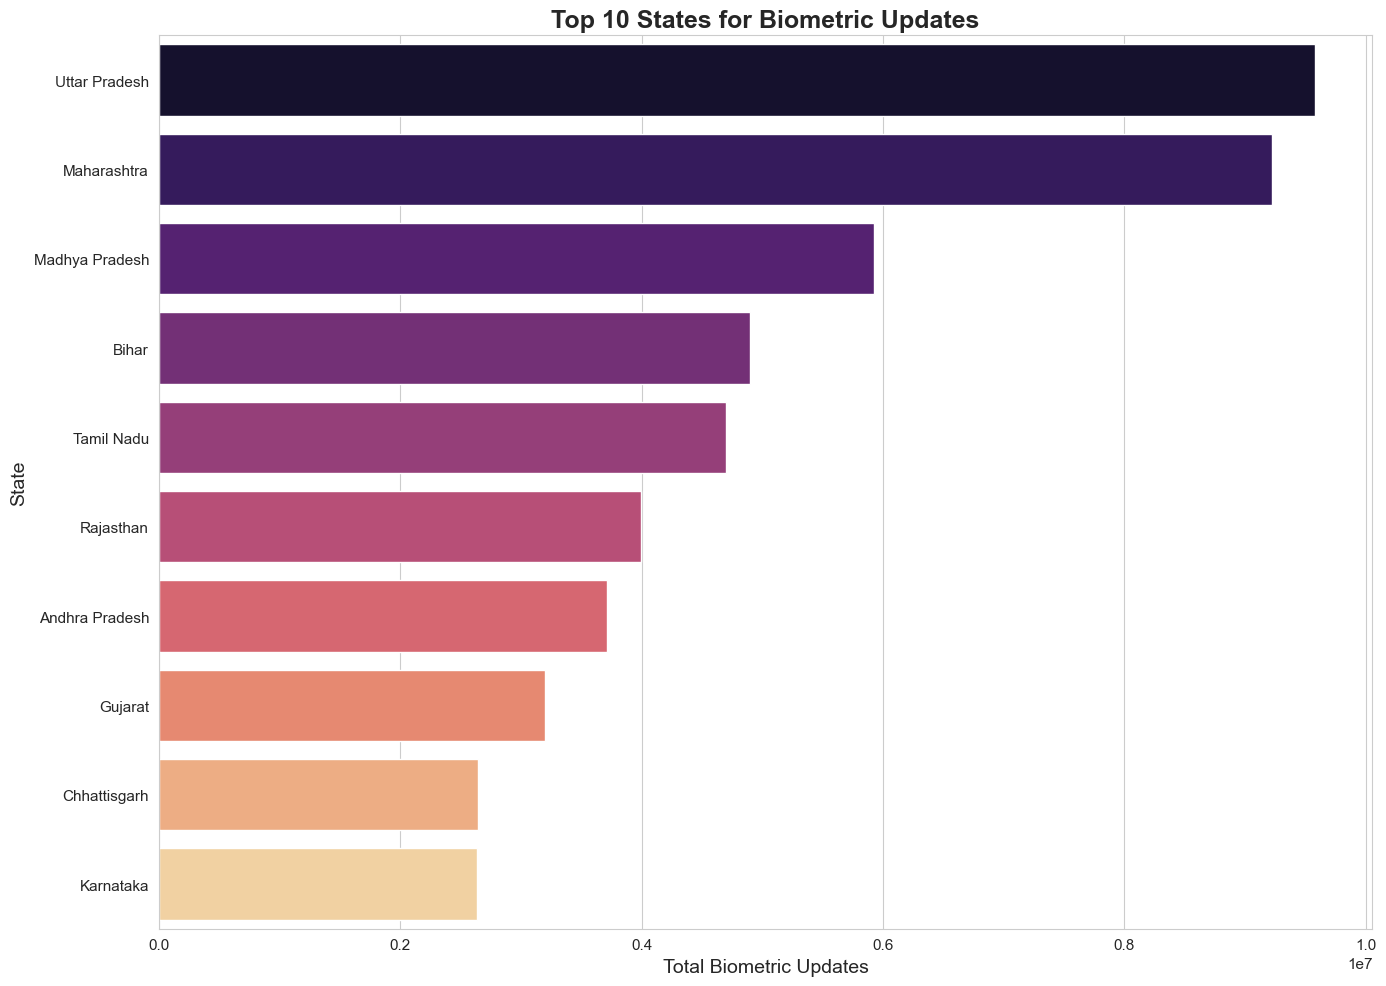

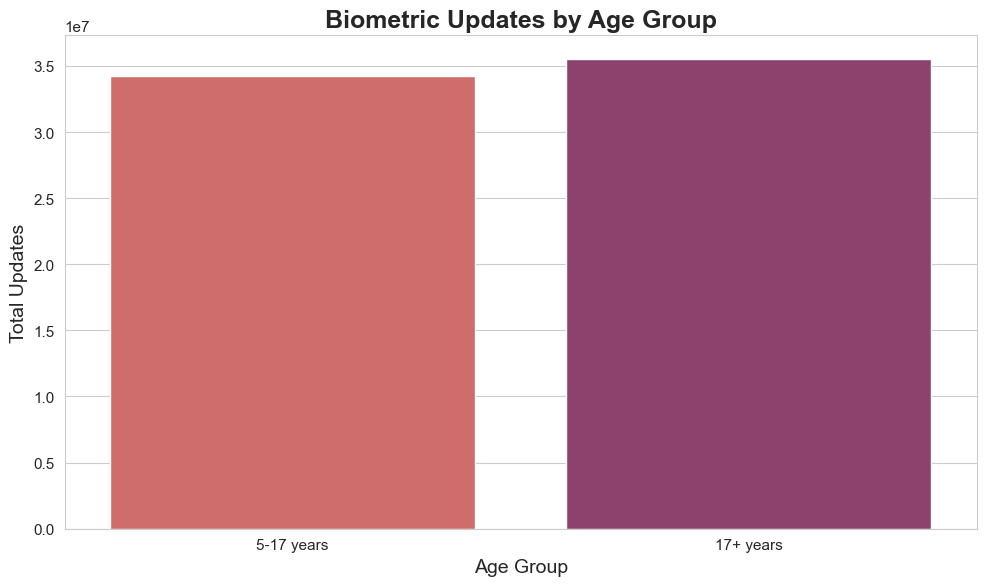

📊 BIOMETRIC UPDATE INSIGHTS:
   🥇 Top State: Uttar Pradesh (9,577,735 updates)
   📌 INSIGHT: High volumes may indicate fingerprint aging or authentication stress
   💡 RECOMMENDATION: Consider mobile authentication units for these states


In [15]:
# Biometric update analysis
if not biometric_df.empty and "state" in biometric_df.columns:
    bio_state = biometric_df.groupby("state")['total_bio_updates'].sum().reset_index()
    bio_state = bio_state.sort_values("total_bio_updates", ascending=False)
    
    bio_state.to_csv("outputs/tables/biometric_updates_by_state.csv", index=False)
    
    # Visualization 1: State-wise
    plt.figure(figsize=(14, 10))
    sns.barplot(data=bio_state.head(10),
                x="total_bio_updates",
                y="state",
                palette="magma")
    plt.title("Top 10 States for Biometric Updates", fontsize=18, fontweight="bold")
    plt.xlabel("Total Biometric Updates", fontsize=14)
    plt.ylabel("State", fontsize=14)
    plt.tight_layout()
    plt.savefig("outputs/charts/biometric_updates.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Visualization 2: Age group comparison
    bio_age_totals = {
        '5-17 years': biometric_df['bio_age_5_17'].sum(),
        '17+ years': biometric_df['bio_age_17_'].sum()
    }
    
    bio_age_df = pd.DataFrame(list(bio_age_totals.items()), columns=['age_group', 'total_updates'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=bio_age_df,
                x="age_group",
                y="total_updates",
                palette="flare")
    plt.title("Biometric Updates by Age Group", fontsize=18, fontweight="bold")
    plt.xlabel("Age Group", fontsize=14)
    plt.ylabel("Total Updates", fontsize=14)
    plt.tight_layout()
    plt.savefig("outputs/charts/biometric_updates_age.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 BIOMETRIC UPDATE INSIGHTS:")
    print(f"   🥇 Top State: {bio_state.iloc[0]['state']} ({bio_state.iloc[0]['total_bio_updates']:,} updates)")
    print(f"   📌 INSIGHT: High volumes may indicate fingerprint aging or authentication stress")
    print(f"   💡 RECOMMENDATION: Consider mobile authentication units for these states")

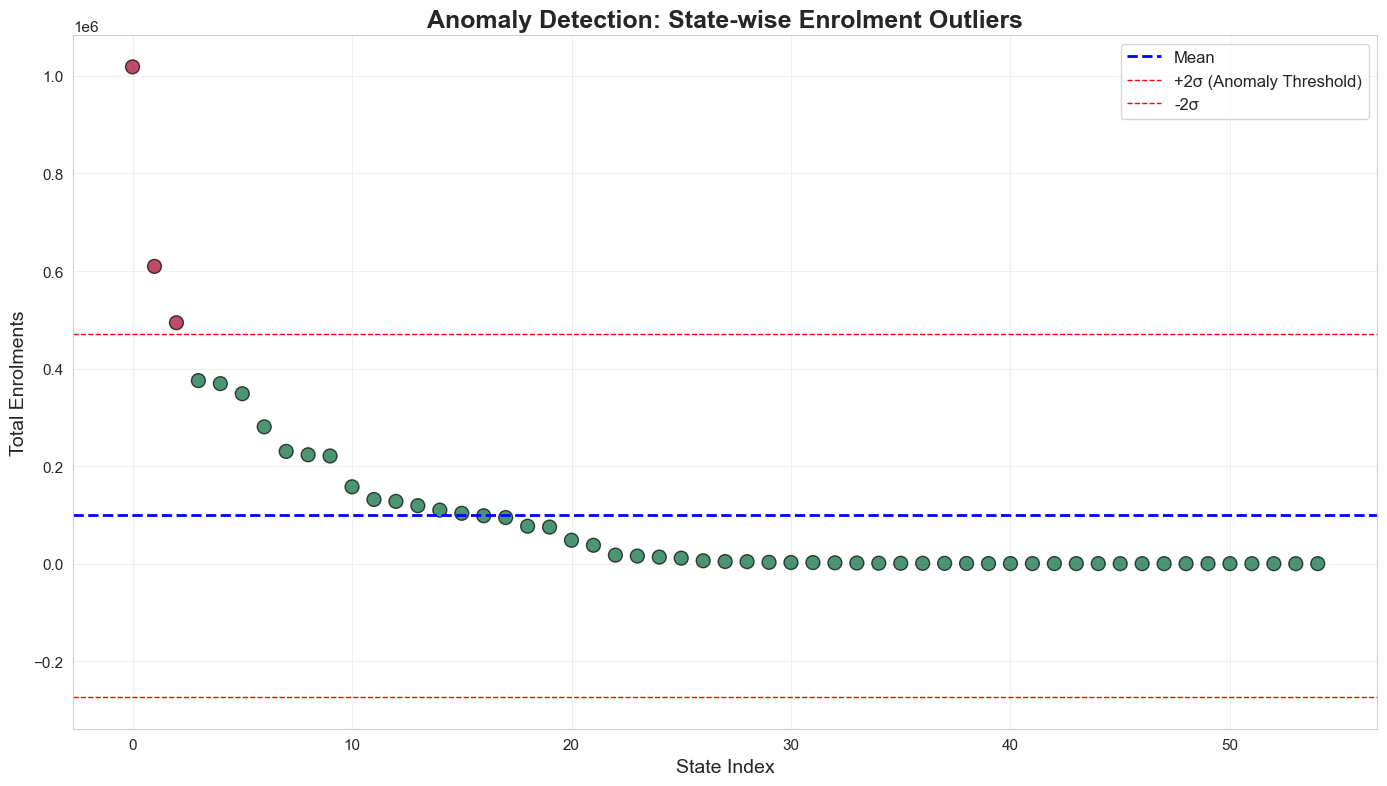

🚨 ANOMALY DETECTION RESULTS:
   Total Anomalies Found: 3

   🔴 HIGH ANOMALIES (Unusually High Enrolments):
      • Uttar Pradesh: 1,018,629 (Z-score: 4.94)
      • Bihar: 609,585 (Z-score: 2.74)
      • Madhya Pradesh: 493,970 (Z-score: 2.12)

   🔵 LOW ANOMALIES (Unusually Low Enrolments):

   💡 RECOMMENDATION: Investigate anomalous states for data quality or operational issues


In [16]:
# Anomaly detection using Z-scores
if not enrolment_df.empty and "state" in enrolment_df.columns:
    # Calculate Z-scores
    state_enrolment["z_score"] = (
        state_enrolment["total_enrolment"] - state_enrolment["total_enrolment"].mean()
    ) / state_enrolment["total_enrolment"].std()
    
    # Identify anomalies (|Z| > 2)
    anomalies = state_enrolment[abs(state_enrolment["z_score"]) > 2].copy()
    anomalies = anomalies.sort_values("z_score", ascending=False)
    anomalies.to_csv("outputs/tables/enrolment_anomalies.csv", index=False)
    
    # Visualization
    plt.figure(figsize=(14, 8))
    plt.scatter(range(len(state_enrolment)), 
                state_enrolment["total_enrolment"],
                c=abs(state_enrolment["z_score"]) > 2,
                cmap='RdYlGn_r',
                s=100,
                alpha=0.7,
                edgecolors='black')
    plt.axhline(y=state_enrolment["total_enrolment"].mean(), 
                color='blue', linestyle='--', linewidth=2, label='Mean')
    plt.axhline(y=state_enrolment["total_enrolment"].mean() + 2*state_enrolment["total_enrolment"].std(),
                color='red', linestyle='--', linewidth=1, label='+2σ (Anomaly Threshold)')
    plt.axhline(y=state_enrolment["total_enrolment"].mean() - 2*state_enrolment["total_enrolment"].std(),
                color='red', linestyle='--', linewidth=1, label='-2σ')
    
    plt.title("Anomaly Detection: State-wise Enrolment Outliers", fontsize=18, fontweight="bold")
    plt.xlabel("State Index", fontsize=14)
    plt.ylabel("Total Enrolments", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("outputs/charts/anomaly_detection.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Report anomalies
    print(f"🚨 ANOMALY DETECTION RESULTS:")
    print(f"   Total Anomalies Found: {len(anomalies)}")
    if len(anomalies) > 0:
        print(f"\n   🔴 HIGH ANOMALIES (Unusually High Enrolments):")
        high_anomalies = anomalies[anomalies['z_score'] > 2]
        for idx, row in high_anomalies.iterrows():
            print(f"      • {row['state']}: {row['total_enrolment']:,} (Z-score: {row['z_score']:.2f})")
        
        print(f"\n   🔵 LOW ANOMALIES (Unusually Low Enrolments):")
        low_anomalies = anomalies[anomalies['z_score'] < -2]
        for idx, row in low_anomalies.iterrows():
            print(f"      • {row['state']}: {row['total_enrolment']:,} (Z-score: {row['z_score']:.2f})")
    
    print(f"\n   💡 RECOMMENDATION: Investigate anomalous states for data quality or operational issues")

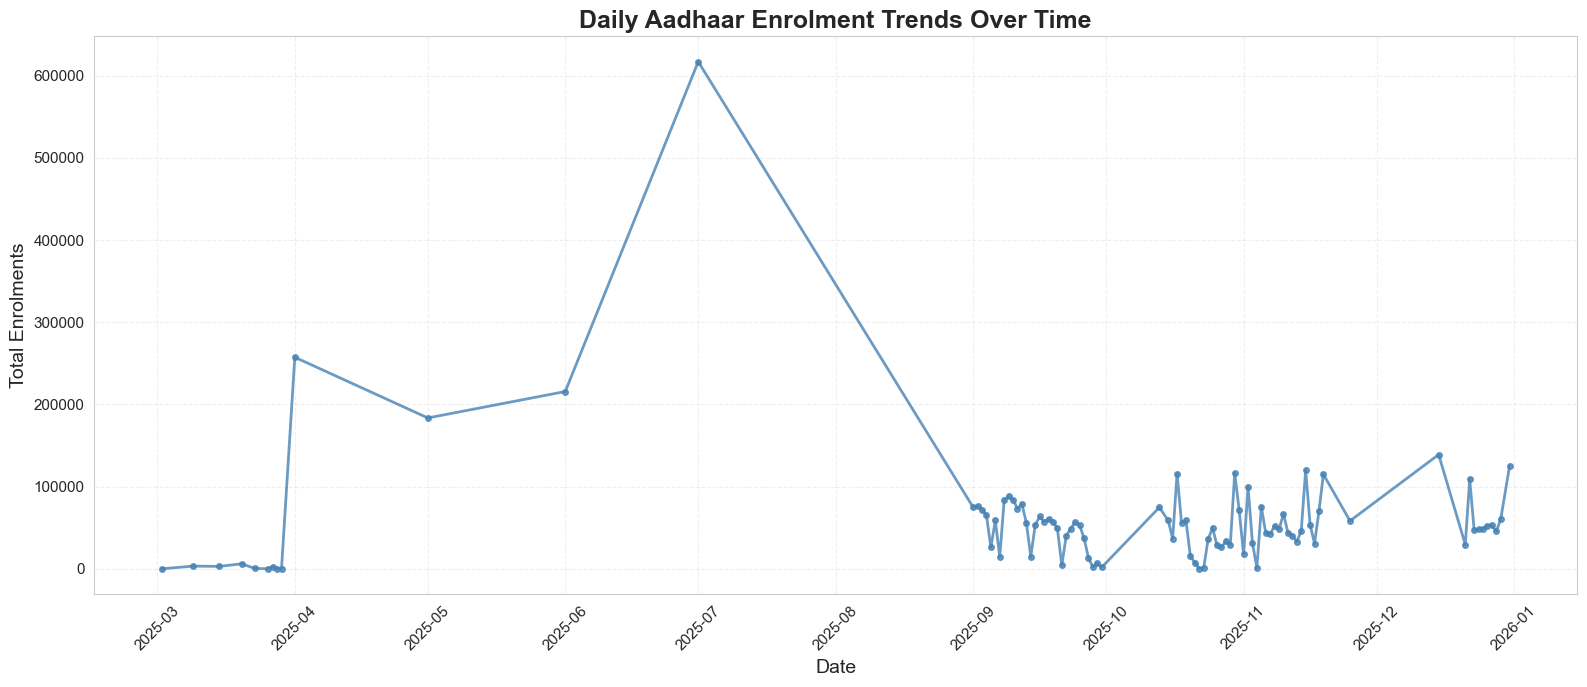

📊 TIME SERIES INSIGHTS:
   Date Range: 02-03-2025 to 31-12-2025
   Total Days: 92
   Peak Day: 01-07-2025 (616,868 enrolments)
   Average Daily Enrolments: 59,084

   💡 INSIGHT: Use trends to schedule resources and predict demand


In [17]:
# Time series analysis
if not enrolment_df.empty and "date" in enrolment_df.columns:
    try:
        # Convert date column
        enrolment_df['date'] = pd.to_datetime(enrolment_df['date'], format='%d-%m-%Y', errors='coerce')
        
        # Remove rows with invalid dates
        enrolment_df = enrolment_df.dropna(subset=['date'])
        
        # Daily enrolment trends
        daily_enrolment = enrolment_df.groupby('date')['total_enrolment'].sum().reset_index()
        daily_enrolment = daily_enrolment.sort_values('date')
        
        daily_enrolment.to_csv("outputs/tables/daily_enrolment_trends.csv", index=False)
        
        # Visualization
        plt.figure(figsize=(16, 7))
        plt.plot(daily_enrolment['date'], 
                daily_enrolment['total_enrolment'], 
                linewidth=2, 
                color='steelblue',
                marker='o',
                markersize=4,
                alpha=0.8)
        
        plt.title("Daily Aadhaar Enrolment Trends Over Time", fontsize=18, fontweight="bold")
        plt.xlabel("Date", fontsize=14)
        plt.ylabel("Total Enrolments", fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.savefig("outputs/charts/time_series_enrolment.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Statistics
        print(f"📊 TIME SERIES INSIGHTS:")
        print(f"   Date Range: {daily_enrolment['date'].min().strftime('%d-%m-%Y')} to {daily_enrolment['date'].max().strftime('%d-%m-%Y')}")
        print(f"   Total Days: {len(daily_enrolment)}")
        print(f"   Peak Day: {daily_enrolment.loc[daily_enrolment['total_enrolment'].idxmax(), 'date'].strftime('%d-%m-%Y')} ({daily_enrolment['total_enrolment'].max():,} enrolments)")
        print(f"   Average Daily Enrolments: {daily_enrolment['total_enrolment'].mean():,.0f}")
        print(f"\n   💡 INSIGHT: Use trends to schedule resources and predict demand")
        
    except Exception as e:
        print(f"⚠️ Time series analysis skipped: {str(e)}")
else:
    print("⚠️ Time series analysis skipped: 'date' column not found")

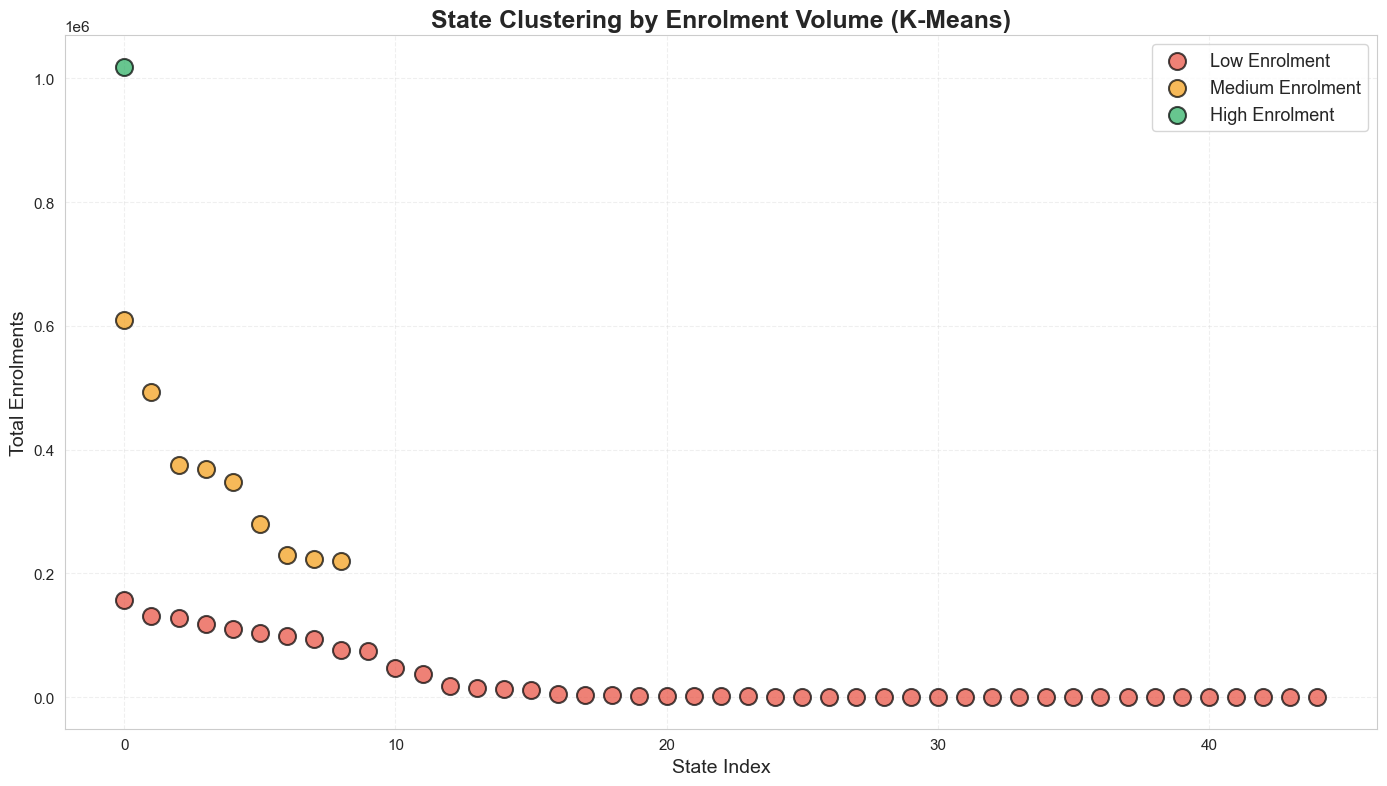

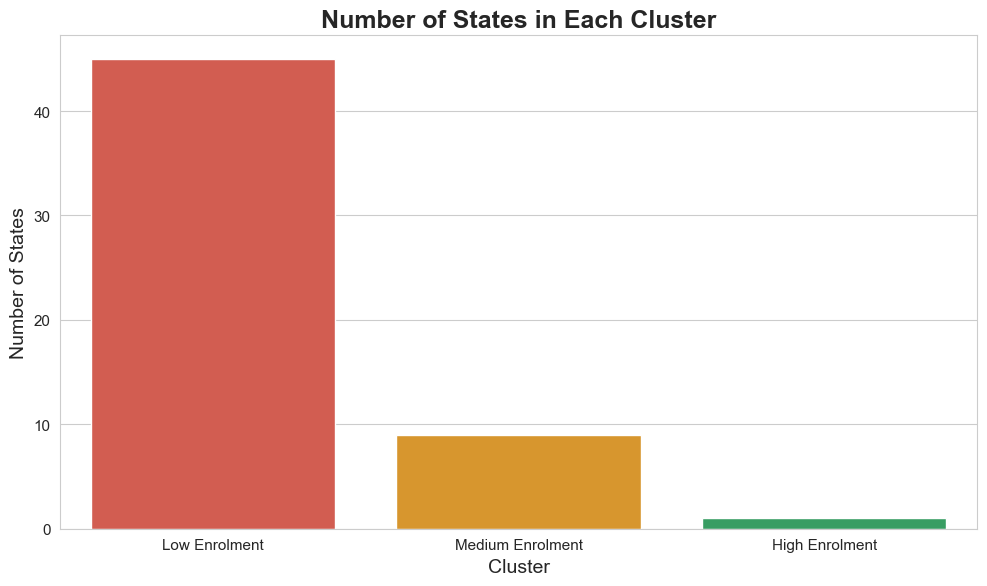

🎯 CLUSTERING RESULTS:

   Low Enrolment Cluster:
      • States: 45
      • Avg Enrolment: 28,130
      • States: Jharkhand, Telangana, Andhra Pradesh, Odisha, Meghalaya
        ... and 40 more

   Medium Enrolment Cluster:
      • States: 9
      • Avg Enrolment: 350,135
      • States: Bihar, Madhya Pradesh, West Bengal, Maharashtra, Rajasthan
        ... and 4 more

   High Enrolment Cluster:
      • States: 1
      • Avg Enrolment: 1,018,629
      • States: Uttar Pradesh

   💡 INSIGHT: Different clusters need different resource allocation strategies
   📌 RECOMMENDATION:
      • High Enrolment: Ensure infrastructure scales with demand
      • Low Enrolment: Deploy mobile units and awareness campaigns


In [18]:
# K-Means Clustering
if not enrolment_df.empty and "state" in enrolment_df.columns:
    try:
        # Prepare features for clustering
        features = state_enrolment[["total_enrolment"]].copy()
        
        # Standardize features
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        
        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        state_enrolment["cluster"] = kmeans.fit_predict(scaled_features)
        
        # Label clusters based on mean enrolment
        cluster_means = state_enrolment.groupby("cluster")["total_enrolment"].mean().sort_values()
        cluster_mapping = {
            cluster_means.index[0]: "Low Enrolment",
            cluster_means.index[1]: "Medium Enrolment",
            cluster_means.index[2]: "High Enrolment"
        }
        state_enrolment["cluster_label"] = state_enrolment["cluster"].map(cluster_mapping)
        
        # Save results
        state_enrolment.to_csv("outputs/tables/state_clusters.csv", index=False)
        
        # Visualization 1: Scatter plot
        plt.figure(figsize=(14, 8))
        colors = {'Low Enrolment': '#e74c3c', 'Medium Enrolment': '#f39c12', 'High Enrolment': '#27ae60'}
        
        for cluster_label in cluster_mapping.values():
            cluster_data = state_enrolment[state_enrolment["cluster_label"] == cluster_label]
            plt.scatter(range(len(cluster_data)), 
                       cluster_data["total_enrolment"],
                       label=cluster_label,
                       s=150, 
                       alpha=0.7,
                       color=colors[cluster_label],
                       edgecolors='black',
                       linewidth=1.5)
        
        plt.title("State Clustering by Enrolment Volume (K-Means)", fontsize=18, fontweight="bold")
        plt.xlabel("State Index", fontsize=14)
        plt.ylabel("Total Enrolments", fontsize=14)
        plt.legend(fontsize=13, loc='best')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.savefig("outputs/charts/state_clustering.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Visualization 2: Cluster distribution
        plt.figure(figsize=(10, 6))
        cluster_counts = state_enrolment["cluster_label"].value_counts()
        sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette=colors)
        plt.title("Number of States in Each Cluster", fontsize=18, fontweight="bold")
        plt.xlabel("Cluster", fontsize=14)
        plt.ylabel("Number of States", fontsize=14)
        plt.tight_layout()
        plt.savefig("outputs/charts/cluster_distribution.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Cluster statistics
        print(f"🎯 CLUSTERING RESULTS:\n")
        for cluster_label in ["Low Enrolment", "Medium Enrolment", "High Enrolment"]:
            cluster_states = state_enrolment[state_enrolment["cluster_label"] == cluster_label]
            print(f"   {cluster_label} Cluster:")
            print(f"      • States: {len(cluster_states)}")
            print(f"      • Avg Enrolment: {cluster_states['total_enrolment'].mean():,.0f}")
            print(f"      • States: {', '.join(cluster_states['state'].head(5).tolist())}")
            if len(cluster_states) > 5:
                print(f"        ... and {len(cluster_states) - 5} more")
            print()
        
        print(f"   💡 INSIGHT: Different clusters need different resource allocation strategies")
        print(f"   📌 RECOMMENDATION:")
        print(f"      • High Enrolment: Ensure infrastructure scales with demand")
        print(f"      • Low Enrolment: Deploy mobile units and awareness campaigns")
        
    except Exception as e:
        print(f"⚠️ Clustering analysis skipped: {str(e)}")

In [19]:
# Generate comprehensive summary statistics
summary_report = {
    "Analysis Type": [
        "State-wise Enrolment",
        "Age Group Distribution",
        "District Analysis",
        "Demographic Updates",
        "Biometric Updates",
        "Anomaly Detection",
        "Time Series Analysis",
        "State Clustering (ML)"
    ],
    "Key Metric": [
        f"{state_enrolment['total_enrolment'].sum():,} total enrolments",
        f"{len(age_enrolment)} age groups analyzed",
        f"{len(district_enrolment)} districts analyzed",
        f"{demo_state['total_demo_updates'].sum():,} total updates",
        f"{bio_state['total_bio_updates'].sum():,} total updates",
        f"{len(anomalies)} anomalous states identified",
        f"{len(daily_enrolment)} days analyzed",
        f"3 clusters identified"
    ],
    "Top Insight": [
        f"Top state: {state_enrolment.iloc[0]['state']}",
        f"18+ years: {age_totals['18+ years']:,}",
        f"Top district: {district_enrolment.iloc[0]['district']}",
        f"Migration hotspot: {demo_state.iloc[0]['state']}",
        f"Authentication stress: {bio_state.iloc[0]['state']}",
        f"Requires investigation",
        f"Peak day: {daily_enrolment.loc[daily_enrolment['total_enrolment'].idxmax(), 'date'].strftime('%d-%m-%Y')}",
        f"High/Medium/Low enrolment groups"
    ]
}

summary_df = pd.DataFrame(summary_report)
print("=" * 80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 80)
print(summary_df.to_string(index=False))
print("=" * 80)

COMPREHENSIVE ANALYSIS SUMMARY
         Analysis Type                    Key Metric                          Top Insight
  State-wise Enrolment    5,435,702 total enrolments             Top state: Uttar Pradesh
Age Group Distribution         3 age groups analyzed                   18+ years: 168,353
     District Analysis        985 districts analyzed                  Top district: Thane
   Demographic Updates      49,295,187 total updates     Migration hotspot: Uttar Pradesh
     Biometric Updates      69,763,095 total updates Authentication stress: Uttar Pradesh
     Anomaly Detection 3 anomalous states identified               Requires investigation
  Time Series Analysis              92 days analyzed                 Peak day: 01-07-2025
 State Clustering (ML)         3 clusters identified     High/Medium/Low enrolment groups


In [20]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
   !jupyter nbconvert --to docx Untitled.ipynb
   

Traceback (most recent call last):
  File "C:\Users\akshi\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
             ~~~~^^
  File "C:\Users\akshi\anaconda3\Lib\site-packages\jupyter_core\application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
    ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\akshi\AppData\Roaming\Python\Python313\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
    ~~~~~~~~~^^
  File "C:\Users\akshi\anaconda3\Lib\site-packages\nbconvert\nbconvertapp.py", line 420, in start
    self.convert_notebooks()
    ~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\akshi\anaconda3\Lib\site-packages\nbconvert\nbconvertapp.py", line 585, in convert_notebooks
    cls = get_exporter(self.export_format)
  File "C:\Users\akshi\anaconda3\Lib\site-packages\nbconvert\exporters\base.py", line 126, in get_exporter
    raise ExporterNameError(msg)
nbconvert

In [28]:
     !jupyter nbconvert --to html Untitled.ipynb
     

[NbConvertApp] Converting notebook Untitled.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Writing 1030596 bytes to Untitled.html


In [29]:
   !pip install nbconvert-docx
   

ERROR: Could not find a version that satisfies the requirement nbconvert-docx (from versions: none)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for nbconvert-docx
